In [ ]:
# This Notebook train 10 VAE to generate each a digit, then train a classifieur to solve mnist only with the VAEs. : result 95% accuracy without much finetuning

In [1]:
%matplotlib inline

from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision

from torch.utils import data
import matplotlib.pyplot as plt

In [2]:
cuda =  torch.cuda.is_available()
batch_size=128
log_interval=100
epochs=10
seed=1


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
class Classif(nn.Module):
    def __init__(self):
        super(Classif, self).__init__()

        self.fc1 = nn.Linear(3*1024, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def classif(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return F.log_softmax(self.fc3(h2))


    def forward(self, x):
        return self.classif(x.view(-1, 3*1024))

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(3*1024, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 3*1024)
        
        self.fc5 = nn.Linear(20, 400) #can eventually share parameters with fc3
        self.fc6 = nn.Linear(400, 10)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def classif(self, z):
        h4 = self.relu(self.fc5(z))
        return F.log_softmax(self.fc6(h4))

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3*1024))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [6]:
def get_list_batch():
    list_digits=[[],[],[],[],[],[],[],[],[],[]]
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size=len(target)
        for i in range(batch_size):
            #list_digits[target[i]].append(batch_idx*batch_size+i)
            list_digits[target[i]].append(data[i])
    return list_digits

def get_batch(list_digits, digit, batch_size):
    liste=list_digits[digit]
    size_list=len(liste)
    plt.imshow(liste[0].numpy()[0])
    batch=np.zeros((batch_size,3,32,32))
    for i in range(batch_size):
        indice=np.random.randint(0, size_list)
        batch[i]=liste[indice].numpy()
    return batch

In [7]:
def add_memories(epoch,data, target):
    mem_size=int(batch_size*epoch/(epochs*2))
    data_mem, label_mem=get_memories(mem_size)
    data[batch_size-mem_size:]=data_mem
    target[batch_size-mem_size:]=label_mem
    #target_discr[batch_size-mem_size:]=torch.zeros(mem_size)
    return data, target
    
def get_memories(size):
    data=np.zeros((size,3,32,32))
    target=np.zeros((size))
    for i in range(size):
        hidden_vector=torch.randn((1,20))
        hidden_vector=Variable(hidden_vector.cuda())
        
        classif=model.classif(hidden_vector)
        target[i]=int(classif.data.max(1)[1].cpu().numpy())
        data[i]=model.decode(hidden_vector).data.cpu().numpy().reshape(3,32,32)
        return torch.from_numpy(data), torch.from_numpy(target)

In [8]:
def train(epoch):
    size_epoch=2000
    model.train()
    train_loss = 0
    train_loss_classif = 0
    digit=(epoch-1)%10
    target = Variable(torch.LongTensor(batch_size).fill_(digit))

    for batch_idx in range(size_epoch):
        data=get_batch(list_digits, digit, batch_size)
        data=torch.FloatTensor(data)
        if epoch>1:
            data, target =add_memories(epoch,data, target)
        data = Variable(data)
        if cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        # VAE
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward(retain_variables=True)
        train_loss += loss.data[0]

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), size_epoch,
                100. * batch_idx / size_epoch,
                loss.data[0] / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / size_epoch))
    print('====> Epoch: {} Average loss classif: {:.4f}'.format(
          epoch, train_loss_classif / size_epoch))
    
    
def test(epoch):
    model_classif.eval()
    test_loss = 0
    test_loss_classif = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data = data.cuda()
            target = target.cuda()
        data = Variable(data, volatile=True)
        target = Variable(target, volatile=True)
        #recon_batch, classif, mu, logvar = model_classif(data)
        classif = model_classif(data)
        #test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        
        
        test_loss_classif  += F.nll_loss(classif, target, size_average=False).data[0] # sum up batch loss
        pred = classif.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_classif , correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = VAE()
if cuda:
    model.cuda()

list_digits=get_list_batch()
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
optimizer = optim.Adam(model.parameters(), lr=1e-3)



Files already downloaded and verified
Files already downloaded and verified


## Print some image

torch.Size([128, 3, 32, 32])
(3, 32, 32)


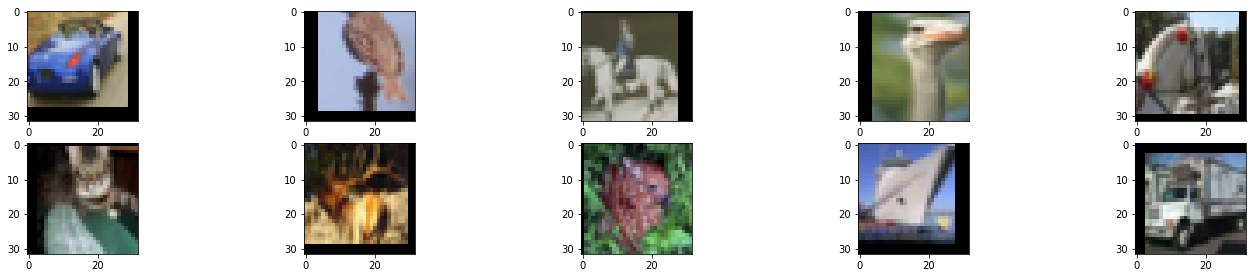

In [41]:
width = 24
height = 24
plt.figure(figsize=(width, height))

batch=0
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    batch=data[:10,:,:,:].cpu().numpy()
    break
print(batch[1].shape)
plt.imshow(np.transpose(batch[1], (1, 2, 0)))
#plt.imshow(batch[1].reshape(32,32,3))
for i in range(10):
    plt.subplot(10,5,i+1)
    sigma=np.array([0.4914, 0.4822, 0.4465])
    mu=np.array([0.2023, 0.1994, 0.2010])
    batch[i]=batch[i]*mu[:,None, None] + sigma[:,None, None]
    plt.imshow(np.transpose(batch[i], (1, 2, 0)))

In [ ]:
import copy
Generators=[]


for epoch in range(1, epochs + 1):
    train(epoch)
    Generators.append(copy.deepcopy(model.decode))

deer


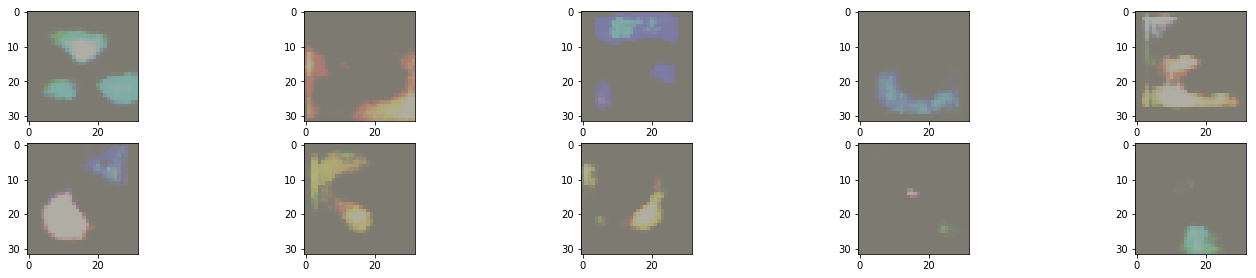

In [49]:
#Testing of decoder's copy 
generator_indice=4
dec=Generators[generator_indice]

print(classes[generator_indice])


width = 24
height = 24
plt.figure(figsize=(width, height))

hidden_vector=torch.randn((10,20))
hidden_vector=Variable(hidden_vector.cuda())

output=dec(hidden_vector)
img=output.data.cpu().numpy().reshape((10,3,32,32))

for i in range(10):
    plt.subplot(10,5,i+1)
    sigma=np.array([0.4914, 0.4822, 0.4465])
    mu=np.array([0.2023, 0.1994, 0.2010])
    img[i]=img[i]*mu[:,None, None] + sigma[:,None, None]
    plt.imshow(np.transpose(img[i], (1, 2, 0)))

In [46]:
def get_batch_VAE(batch_size, Generators):
    #dirty way of gettingrandom integer for Generators selection
    gene_indice=(torch.randperm(1000)%10)[0:batch_size]
    hidden_vectors=torch.randn((1,20,batch_size))
    batch=torch.FloatTensor(batch_size,28,28)
    target=torch.LongTensor(batch_size)
    for i in range(batch_size):
        target[i]=int(gene_indice[i])
        gene=Generators[target[i]]
        h=Variable(hidden_vectors[:,:,i].cuda())
        batch[i]=gene(h).data.cpu()
    return batch, target

In [ ]:
def train_from_VAE(epoch):
    size_epoch=1000
    model_classif.train()
    train_loss = 0
    train_loss_classif = 0

    for batch_idx in range(size_epoch):
        
        data,target=get_batch_VAE(batch_size, Generators)
        data = Variable(data)
        target = Variable(target)
        if cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        
        # Classif
        classif = model_classif(data)
        loss_classif = F.nll_loss(classif, target)
        loss_classif.backward(retain_variables=True)
        train_loss_classif += loss_classif.data[0]

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), size_epoch,
                100. * batch_idx / size_epoch,
                train_loss_classif / len(data)))
    print('====> Epoch: {} Average loss classif: {:.4f}'.format(
          epoch, train_loss_classif / size_epoch))

In [ ]:
model_classif=Classif()
model_classif=model_classif.cuda()
optimizer = optim.Adam(model_classif.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train_from_VAE(epoch)
    test(epoch)

# Print sample from the different VAE trained to train the classifieur

In [ ]:
width = 24
height = 24
plt.figure(figsize=(width, height))


batch,target=get_batch_VAE(10, Generators)
img=batch.numpy().reshape((10,28,28))
for i in range(10):
    plt.subplot(10,5,i+1)
    plt.imshow(img[i])

# random sample after training with memories. Only half the sample are memories at the end of training (92%)

In [ ]:
width = 24
height = 24
plt.figure(figsize=(width, height))

hidden_vector=torch.randn((10,20))
#hidden_vector=torch.ones((10,20))*0.0
#hidden_vector[0]=torch.from_numpy(np.array(range(20))*0.05)

hidden_vector=Variable(hidden_vector.cuda())
classif=model.classif(hidden_vector)

output=model.decode(hidden_vector)
img=output.data.cpu().numpy().reshape((10,28,28))

for i in range(10):
    plt.subplot(10,5,i+1)
    plt.imshow(img[i])
print(classif.data.max(1)[1].cpu().numpy().transpose().reshape(2,5))

#print(np.exp(classif.data.cpu().numpy()).transpose())


np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(np.exp(classif.data.cpu().numpy()))